# **Image Generation using Generative Adversial Network with help of Tensorflow and python**
  A hands-on project that involves creating a Generative Adversarial Network (GAN) model in Python with the TensorFlow library. This project focuses on implementing a generator and discriminator network to generate realistic data samples from random noise and distinguish between real and fake samples. Through training, the generator learns to produce increasingly realistic data, while the discriminator becomes more adept at differentiating between real and fake samples. By exploring GAN architectures and loss functions, this project offers a practical understanding of deep learning concepts and their application in generating synthetic data.









##1. Import Dependencies and Data


In [ ]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 matplotlib==3.5.1 tensorflow-datasets==4.5.2 ipywidgets

In [ ]:
# Bringing in tensorflow
import tensorflow as tf

# For Constrainig limit of GPU's in local machine
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#Bringing in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
#For visualizing stuff in form of plots
from matplotlib import pyplot as plt


In [ ]:
#Now import fashion_mnist only the training part
ds = tfds.load(name='fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteN6M4V9/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteN6M4V9/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds.as_numpy_iterator().next()

# 2.Visualising Data using Matplotlib

In [ ]:
# Do some data transformation
import numpy as np

In [ ]:
# Setup connection aka iterator for calling new images batch for training all the time
dataiterator = ds.as_numpy_iterator()

In [ ]:
# Getting data out of the pipeline
dataiterator.next()['image']

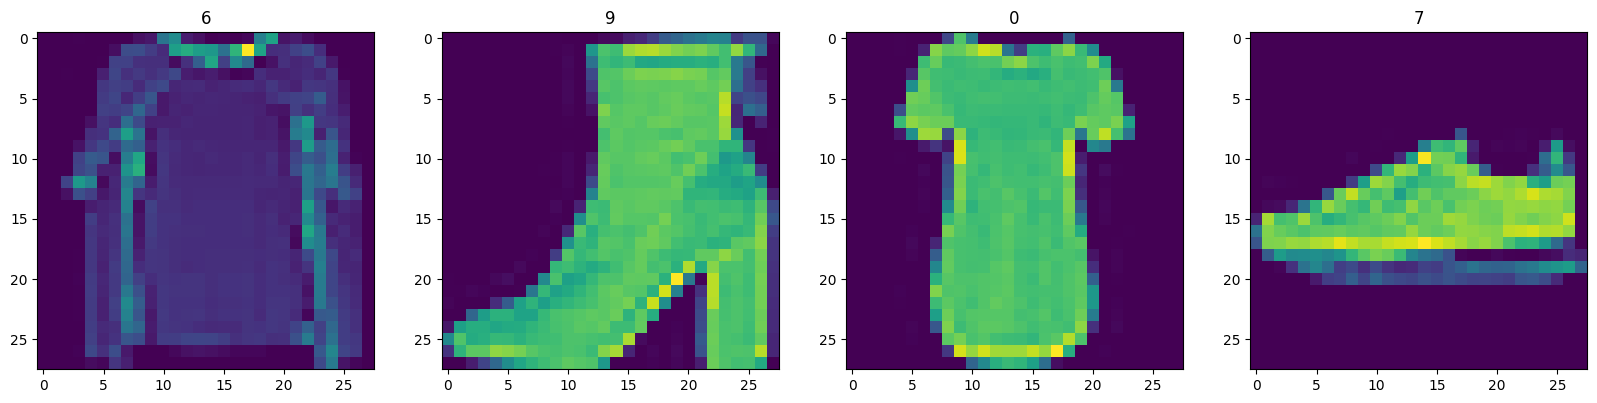

In [ ]:
# Setup the subplot formatting like suplot size and  no of columns
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

# Loop four times and get images
for idx in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot here squeeze will squeeze one dimension from (28,28,1) and makes it (28,28) - basically use to collapse our array
    ax[idx].imshow(np.squeeze(sample['image']))

    # Appending the image label as the plot title
    ax[idx].title.set_text(sample['label'])

scale images - data processing because images are in between (0-255) but for better result we keep it between 0-1 .

In [ ]:
# Scale and return image only
def scale_images(data):
  image = data['image']
  return image/255

In [ ]:
# map ,cache , shuffle , batch , prefetch - 5 steps for building a data pipeline for tensorflow

# Reload the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking - it means reduce of generating repeative images
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape #Its shows 128 * 28 * 28 * 1 - 128 images of dimension 28*28*1

# 3. Build Neural Network


3.1 Import Modelling Components


1.   Keras - A high level neural network API - for building,training and deploying deep learning models.Used for prototyping mostly
2.   Tensorflow - a ML library for building various ML models. It contains both high level and low level apis.

In keras we use layers for customizing our model architecture as per our needs.
---





In [ ]:
# Bring in the sequential api for the generator and discriminator - one input and one output - one way flow
from tensorflow.keras.models import Sequential

# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
# Convo2D -  to perform convolution- processing AND extracting input data.feature extraction
# Dense - to dense a layer to requirement
# flatten - to flatten a matrices or arrays
# Reshape - to reshape accordingly with transform input or output layers
# LeakyRelu - a bit leaky or we can say cross Relu - recti-linear unit - activation function is mathematical operation applied to the output of a neuron (or a layer of neurons) to introduce non-linearity into the network to learn non linear complex problems.
# Dropout - a form of regularization
# UpSampling2D - to upsample the image in generator - add a bit space to an image

Build A Generator Model

In [ ]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128)) # Random noise genrated and why 7*7*128 because would be great for low resolution image for feature engineering
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128))) # reshape

    # Upsampling block 1
    model.add(UpSampling2D()) #transofrming low resolution to high resolution image
    model.add(Conv2D(128, 5, padding='same')) # refine the features
    model.add(LeakyReLU(0.2)) # This ensures that neurons continue to receive updates during training, preventing them from becoming stuck in an inactive state.

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [ ]:
generator = build_generator()


In [ ]:
generator.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

In [ ]:
img = generator.predict(np.random.randn(4,128,1))


1/1 [==============================] - 0s 114ms/step


In [ ]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 121ms/step


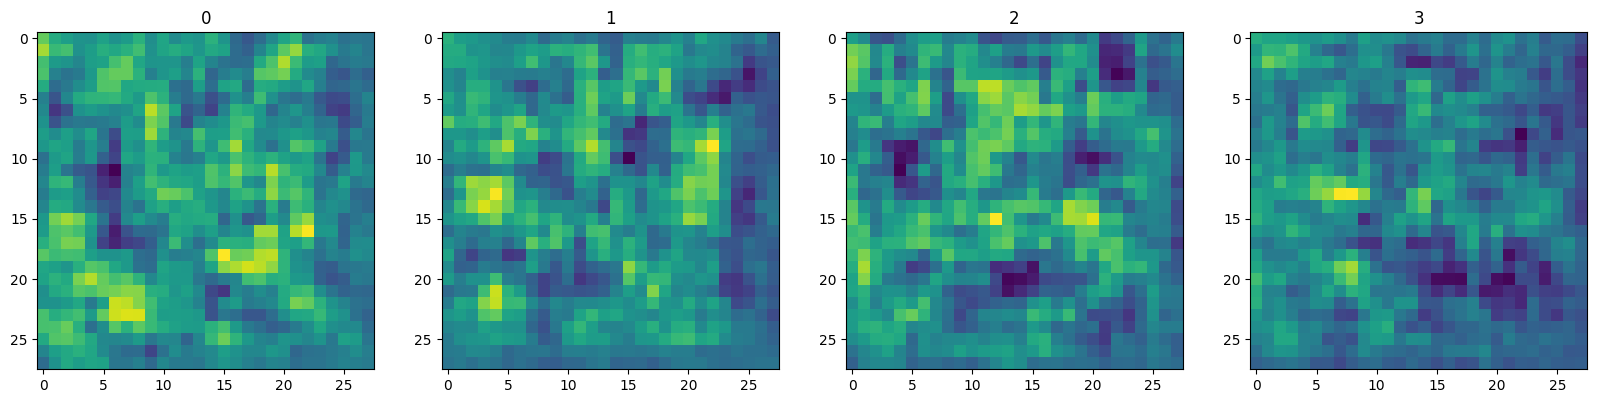

In [ ]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

Build A Discriminator Model

In [ ]:
def build_discriminator():
    model = Sequential()

    # Convolution block 1
    model.add(Conv2D(32, 5, input_shape=(28,28,1))) # 32 filters of 5*5
    model.add(LeakyReLU(0.2)) # mostly used when builting GAN's for better models
    model.add(Dropout(0.4)) # to prevent overfitting / regularization

    # Convolution block 2
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolution block 3
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolution block 4
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten
    model.add(Flatten()) # flatten into 1D array - process entire image as single vector image

    # Output layer
    model.add(Dense(1, activation='sigmoid')) # dimenstionality of output layer - one neuron in dense layer connected to every neuron in precedeeing layer

    return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)      

In [ ]:
img

In [ ]:
img.shape


(28, 1)

In [ ]:
discriminator.predict(img)


1/1 [==============================] - 0s 98ms/step


array([[0.5015814 ],
       [0.5013263 ],
       [0.50157195],
       [0.50156516]], dtype=float32)

# 4. Construct Training Loop


4.1 Setup Losses and Optimizers


In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

4.2 Build Subclassed Model


In [ ]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [ ]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss

4.3 Build Callback


In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

**4.3 Train**

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=2000, callbacks=[ModelMonitor()])

**4.4 Review Performance**

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

### **5. Test Out the Generator**

**5.1 Generate Images**

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))


In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))


In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

**5.2 Save the Model**

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')